In [51]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import pandas as pd
import os

In [167]:
files = []
PATH = "/Users/marron31/repos/bcm4rcm/data/processed"
for file in os.listdir(PATH):
    if file.endswith(".csv"):
        if '1961' in file:
            files.append(os.path.join(PATH, file))
            
files

['/Users/marron31/repos/bcm4rcm/data/processed/historical_MPI_IITM_1961_1975.csv',
 '/Users/marron31/repos/bcm4rcm/data/processed/historical_CSIRO_1961_1975.csv',
 '/Users/marron31/repos/bcm4rcm/data/processed/historical_MPI-REMO2009_1961_1975.csv',
 '/Users/marron31/repos/bcm4rcm/data/processed/historical_NOAA_SMHI_1961_1975.csv',
 '/Users/marron31/repos/bcm4rcm/data/processed/historical_MIROC_1961_1975.csv']

In [53]:
def aggregate_to_4d_array(df, agg_func='mean'):
    """
    Aggregates values from a DataFrame for each month, latitude, longitude, and year,
    then reshapes the result into a 4D NumPy array.
    
    Parameters:
    - df: Pandas DataFrame with columns ['time', 'lat', 'lon', 'tp']
    - agg_func: String name of the aggregation function to use (e.g., 'mean', 'sum')
    
    Returns:
    - A 4D NumPy array with shape [12, 90, 40, -1], where -1 is the number of years
    """
    # Ensure 'time' is a datetime type
    df['time'] = pd.to_datetime(df['time'])
    
    # Extract month and year
    df['month'] = df['time'].dt.month
    df['year'] = df['time'].dt.year - df['time'].dt.year.min()  # Normalize year
    
    # Group and aggregate
    aggregated_df = df.groupby(['month', 'lat', 'lon', 'year'])['tp'].agg(agg_func).reset_index()
    
    # Pivot
    pivoted_df = aggregated_df.pivot_table(index=['month', 'lat', 'lon'], columns='year', values='tp', fill_value=0)
    
    # Convert to a 4D array and reshape
    num_years = len(df['year'].unique())
    result_array = pivoted_df.values.reshape((12, 90, 40, num_years))
    
    return result_array

# Example usage:
# Assuming your DataFrame is named df and has the required columns
# result_array = aggregate_to_4d_array(df, agg_func='mean')
# Now result_array is the desired 4D array


In [54]:
rcm_dict = {}
for file in files:
    df = pd.read_csv(file)
    df = aggregate_to_4d_array(df)
    rcm_dict[file.split('/')[-1].split('_')[1]] = df

In [55]:
for k,v in rcm_dict.items():
    print(k, v.shape)

MPI (12, 90, 40, 15)
CSIRO (12, 90, 40, 15)
MPI-REMO2009 (12, 90, 40, 15)
NOAA (12, 90, 40, 15)
MIROC (12, 90, 40, 15)


In [56]:
np.random.seed(0)

In [57]:
weights_dict = {}
for k,v in rcm_dict.items():
    weights_dict[k] = np.round(np.random.rand(1),2)

In [58]:
for k,v in rcm_dict.items():
    v = np.repeat(v, int(weights_dict[k]*100), axis=3)
    rcm_dict[k] = v

/var/folders/20/mmwsmqln50jb9dbszgvt2l240000gp/T/ipykernel_95145/1660977929.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  v = np.repeat(v, int(weights_dict[k]*100), axis=3)


In [59]:
for k,v in rcm_dict.items():
    print(v.shape)

(12, 90, 40, 825)
(12, 90, 40, 1080)
(12, 90, 40, 900)
(12, 90, 40, 810)
(12, 90, 40, 630)


In [60]:
# Creata a 5D array with the values for all the RCMs
rcms = np.concatenate([rcm_dict[i] for i in list(rcm_dict.keys())], axis=-1)

In [260]:
def log_transform(data, epsilon=1e-5):
    return np.log(data + epsilon)

def compute_kde(data):
    """
    Computes the Kernel Density Estimation (KDE) for each sample in a 4-dimensional array.
    
    Parameters:
    - data: A 4-dimensional NumPy array where the first three dimensions are used to 
            iterate over, and the last dimension contains the data samples for KDE.
    
    Returns:
    - rcms_kde: A 3-dimensional NumPy array of the same shape as the first three dimensions
                   of the input data, containing KDE objects for each sample.
    """
    # Initialize an empty array for KDE results with the same shape as the first three dimensions of data
    rcms_kde = np.empty(data.shape[:-1], dtype=object)
    
    # Iterate over the array
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            for k in range(data.shape[2]):
                # Extract the vector
                sample = data[i, j, k, :]
                
                # Apply KDE
                kde = gaussian_kde(sample)
                
                # Store the KDE object
                rcms_kde[i, j, k] = kde
                
    return rcms_kde

In [261]:
# Apply the log transformation
log_rcms = log_transform(rcms, epsilon=1e-5)

In [262]:
# Compute the KDE
rcms_kde = compute_kde(log_rcms)

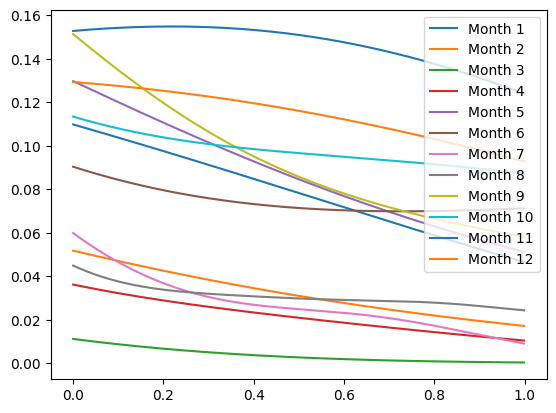

In [263]:
for idx, kde in enumerate(rcms_kde[:, 0, 0]):
    x = np.arange(0, 1, 0.001)
    y = kde.evaluate(x)
    plt.plot(x, y, label=f'Month {idx + 1}')
plt.legend()
plt.show()

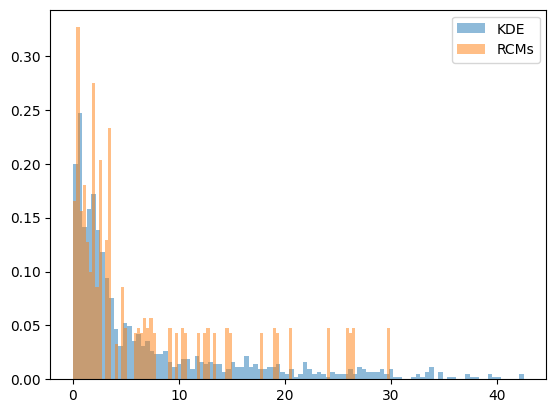

In [264]:
i = 7
j = 5
k = 6

plt.hist(np.exp(rcms_kde[i,j,k].resample(1000)).reshape(-1)-epsilon, bins=100, alpha=0.5, label='KDE', density=True)
plt.hist(np.exp(data[i,j,k,:])-epsilon, bins=100, alpha=0.5, label='RCMs', density=True)
plt.legend()
plt.show()

### APHRODITE

In [265]:
df = pd.read_csv(files[0])

In [266]:
PATH = "/Users/marron31/repos/bcm4rcm/data/APHRODITE/aphrodite_hma_1951_2016.nc"
ds = xr.open_dataset(PATH)

In [267]:
# select data for  period 1961-1975 and spatial extent of interest
ds_sel = ds.sel(time=slice('1961-01-01', '1975-12-31')).sel(lat=slice(20, 40), lon=slice(60, 105))

In [268]:
# Interpolate original dataset to the new coordinates
interpolated_ds = ds_sel.interp(lat=df.lat.unique(), lon=df.lon.unique(), method='linear', kwargs={"fill_value": "extrapolate"})

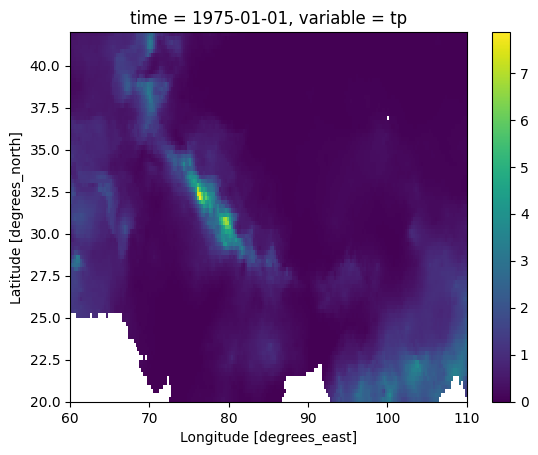

In [269]:
ds.sel(time='1975-01-01').to_array().plot()
plt.show()

In [272]:
aphro = interpolated_ds.to_array()

In [275]:
# Step 1: Extract month and year from the 'time' dimension
interpolated_ds['month'] = interpolated_ds['time'].dt.month


In [276]:
tp = np.array(aphro[0,...])
aprho_months = np.array(aphro[1,...])

for month in range(1, 13):
    # Find indices where the second array equals the current month
    indices = np.where(aprho_months == month, 1, np.NaN)
    to_keep = ~np.all(np.isnan(np.multiply(tp,indices)[...]), axis=(1,2))
    filtered_tp = tp[to_keep,...]
    if month == 1:
        filtered_tp_all = filtered_tp
    elif month == 2:
        # print(filtered_tp_all.shape, filtered_tp.shape)
        filtered_tp_all = np.stack((filtered_tp_all, filtered_tp), axis=0)
    else:
        # print(filtered_tp_all.shape, filtered_tp.shape)
        filtered_tp_all = np.concatenate((filtered_tp_all, np.expand_dims(filtered_tp, axis=0)), axis=0)
    

In [277]:
# Transpose the array to have the dimensions in the order (month, lat, lon, year)
aprho = filtered_tp_all.transpose(0, 3, 2, 1)

In [278]:
# Replace NaNs with zeros - for stability in the KDE computation but to be reviewed
aphro_no_nans = np.nan_to_num(aprho, copy=False, nan=0.0, posinf=0.0, neginf=0.0)

In [279]:
# Apply the log transformation
log_aphro = log_transform(aphro_no_nans, epsilon=1e-5)

In [280]:
aphros_kde = compute_kde(log_aphro)

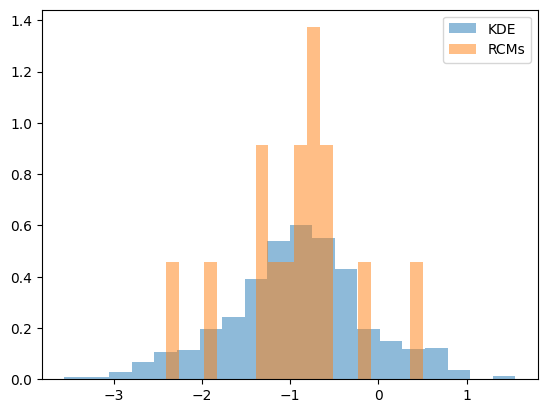

In [281]:
i = 7
j = 30
k = 30

plt.hist(aphros_kde[i,j,k].resample(1000).reshape(-1), bins=20, alpha=0.5, label='KDE', density=True)
plt.hist(log_aphro[i,j,k,:], bins=20, alpha=0.5, label='RCMs', density=True)
plt.legend()
plt.show()